## Working GRB
This is the GRB 050128, with 2ms time gap between points.
Works as expected:-

| No of Data Points    | Time Taken |
| -------- | -------   |
|  25      |  9 sec    |
| 120      |  12 sec   |
| 1000     |  4mins    |


## Loading Dependencies

In [11]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import seaborn as sns
sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

## Loading Data:
This code is mainly to pick up the text file of the specified GRB and convert it into a numpy arrays

In [12]:
def truncate_data(times: np.ndarray, counts: np.ndarray, start: float, stop: float, yerr: np.ndarray = None) -> tuple:
    indices = np.where(np.logical_and(times > start, times < stop))[0]
    if yerr is None:
        return times[indices], counts[indices]
    else:
        return times[indices], counts[indices], yerr[indices]

def get_grb_data_from_segment(
        grb_id: str, grb_binning: str, start_time: float, end_time: float, grb_detector: str = None,
        grb_energy_band: str = "all", grb_label: str = None, bin_size: str = None, **kwargs) -> tuple:
    times, y, yerr = get_all_grb_data(grb_binning=grb_binning, grb_id=grb_id, grb_detector=grb_detector,
                                      grb_label=grb_label, grb_energy_band=grb_energy_band, bin_size=bin_size)
    return truncate_data(times=times, counts=y, start=start_time, stop=end_time, yerr=yerr)


def get_all_grb_data(
        grb_id: str, grb_binning: str, grb_detector: str = None, grb_energy_band: str = "all", grb_label: str = None,
        bin_size: str = None, **kwargs) -> tuple:
    if grb_detector in ["swift", "konus"]:
        data_file = f"data/GRBs/GRB{grb_id}/{grb_binning}_lc_ascii_{grb_detector}.txt"
        data = np.loadtxt(data_file)
        times = data[:, 0]
        if grb_detector == "swift":
            if grb_energy_band == "15-25":
                y = data[:, 1]
                yerr = data[:, 2]
            elif grb_energy_band == "25-50":
                y = data[:, 3]
                yerr = data[:, 4]
            elif grb_energy_band == "50-100":
                y = data[:, 5]
                yerr = data[:, 6]
            elif grb_energy_band == "100-350":
                y = data[:, 7]
                yerr = data[:, 8]
            elif grb_energy_band in ["all", "15-350"]:
                y = data[:, 9]
                yerr = data[:, 10]
            else:
                raise ValueError(f"Energy band {grb_energy_band} not understood")
            return times, y, yerr
        elif grb_detector == "konus":
            y = data[:, 1]
            return times, y, np.sqrt(y)
    elif grb_detector == "batse":
        data_file = f"data/GRBs/GRB{grb_id}/GRB{grb_id}_{grb_energy_band}"
        data = np.loadtxt(data_file)
        times = data[:, 0]
        y = data[:, 1]
        yerr = np.sqrt(y)
        return times, y, yerr
    elif grb_detector.lower() == "asim":
        data_file = f"data/GRBs/GRB{grb_id}/{grb_label}.txt"
        ttes = np.loadtxt(data_file)
        y, bin_edges = np.histogram(ttes, np.arange(ttes[0], ttes[-1], bin_size))
        times = np.array([bin_edges[i] + (bin_edges[i + 1] - bin_edges[i]) / 2 for i in range(len(bin_edges) - 1)])
        yerr = np.sqrt(y)
        return times, y, yerr
    
_GRB_RUN_MODES = dict(select_time=get_grb_data_from_segment,
                      entire_segment=get_all_grb_data)

def get_grb_data(run_mode: str, **kwargs) -> tuple:
    """ Catch all function """
    return _GRB_RUN_MODES[run_mode](**kwargs)

## Labels for our GRB

In [17]:
grb_id = "050128"
grb_label = ""
grb_binning = "2ms"
grb_detector = "swift"
grb_energy_band = "all"

times, y, yerr = get_all_grb_data(
        grb_id = grb_id, grb_binning = grb_binning, grb_detector = grb_detector, 
        grb_energy_band = grb_energy_band, grb_label= grb_label,
        bin_size= None)

print(times.shape, y.shape, yerr.shape)

(1000,) (1000,) (1000,)


#### Plotting the Total Lightcurve
Has a 1000 points

<ErrorbarContainer object of 3 artists>

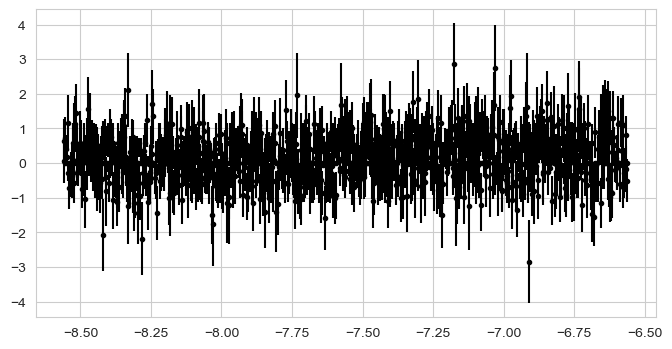

In [18]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.errorbar(times, y, yerr=yerr, fmt=".k", capsize=0, label="data")

## Slicing the GRB
Here We can slice the data by putting the start and end time that we want to use

**Saved as times2, y2, yerr2**

Example from t = -7.75 to t = -7.70

In this demo, file, I have taken all the 1000 points

In [58]:
times2, y2, yerr2 = get_grb_data_from_segment(
        grb_id = grb_id, grb_binning = grb_binning, start_time = -7.75, end_time = -7.70, grb_detector = grb_detector,
        grb_energy_band = grb_energy_band, grb_label = grb_label, bin_size= None)
times2 = jnp.asarray(times2)
y2 = jnp.asarray(y2)
yerr2 = jnp.asarray(yerr2)
print(times2.shape, y2.shape, yerr2.shape)

(25,) (25,) (25,)


<ErrorbarContainer object of 3 artists>

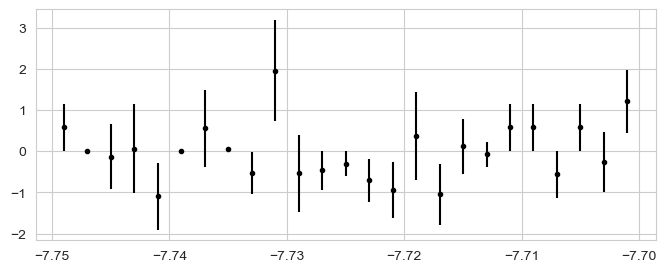

In [59]:
fig, ax = plt.subplots(1,1, figsize = (8,3))
ax.errorbar(times2, y2, yerr=yerr2, fmt=".k", capsize=0, label="data")

## Posterior Sampling

For full data (1000 points) ie. **times, y, yerr**. To use sliced lightcurve, use **times2, y2, yerr2**

In [46]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow_probability.substrates.jax as tfp
from gpmodelling import get_prior, get_likelihood, get_gp_params, get_kernel, get_mean
tfpd = tfp.distributions
tfpb = tfp.bijectors

from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

In [54]:
params_list = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")

counts = y
total_time = time[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

prior_dict = {
    "A": tfpd.Uniform(low = 0.1 * span , high= 2 * span ),
    "t0": tfpd.Uniform(low = times[0] - 0.1*total_time, high = times[-1] + 0.1*total_time),
    "sig": tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * total_time ),

    "arn": tfpd.Uniform(low = 0.1 * span , high = 2 * span ),
    "crn": tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f)),
    
    "aqpo": tfpd.Uniform(low = 0.1 * span, high = 2 * span ),
    "cqpo": tfpd.Uniform(low = 1/10/total_time, high = jnp.log(f)),
    "freq": tfpd.Uniform(low = 2 , high = f/4 ),
}

prior_model4 = get_prior(params_list, prior_dict)

likelihood_model4 = get_likelihood(params_list, kernel_type= "QPO_plus_RN", 
                                    mean_type = "gaussian", Times = times, 
                                    counts = counts)

In [55]:
from jaxns import ExactNestedSampler, TerminationCondition, Prior, Model
from jax import random

NSmodel = Model(prior_model=prior_model4, log_likelihood=likelihood_model4)
NSmodel.sanity_check(random.PRNGKey(10), S=100)

Exact_ns = ExactNestedSampler(NSmodel, num_live_points=500, max_samples=1e4)
Termination_reason, State = Exact_ns(
    random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
)
Results = Exact_ns.to_results(State, Termination_reason)
print("Simulation Complete")

INFO[2023-08-03 13:17:20,358]: Sanity check...
INFO[2023-08-03 13:17:20,360]: Sanity check passed


Simulation Complete


In [56]:
Exact_ns.summary(Results)

--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 1725795
# samples: 10000
# slices: 876540.0
# slices / acceptance: 105.0
# likelihood evals / sample: 172.6
# likelihood evals / slice: 2.0
--------
logZ=-1354.56 +- 0.17
H=1400.0
ESS=879
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 2.6 +- 1.5 | 1.0 / 2.1 / 5.0 | 1.3 | 1.3
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 11.302 +- 0.1 | 11.175 / 11.335 / 11.395 | 11.309 | 11.309
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 3.7 +- 1.9 | 1.8 / 3.1 / 7.0 | 1.1 | 1.1
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 6.162 +- 0.051 | 6.098 / 6.178 / 6.21 | 6.208 | 6.208
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 0.74 +- 0.38 | 0.3 / 0.68 / 1.23 | 2.31 | 2.31
--------
freq: mean +- 

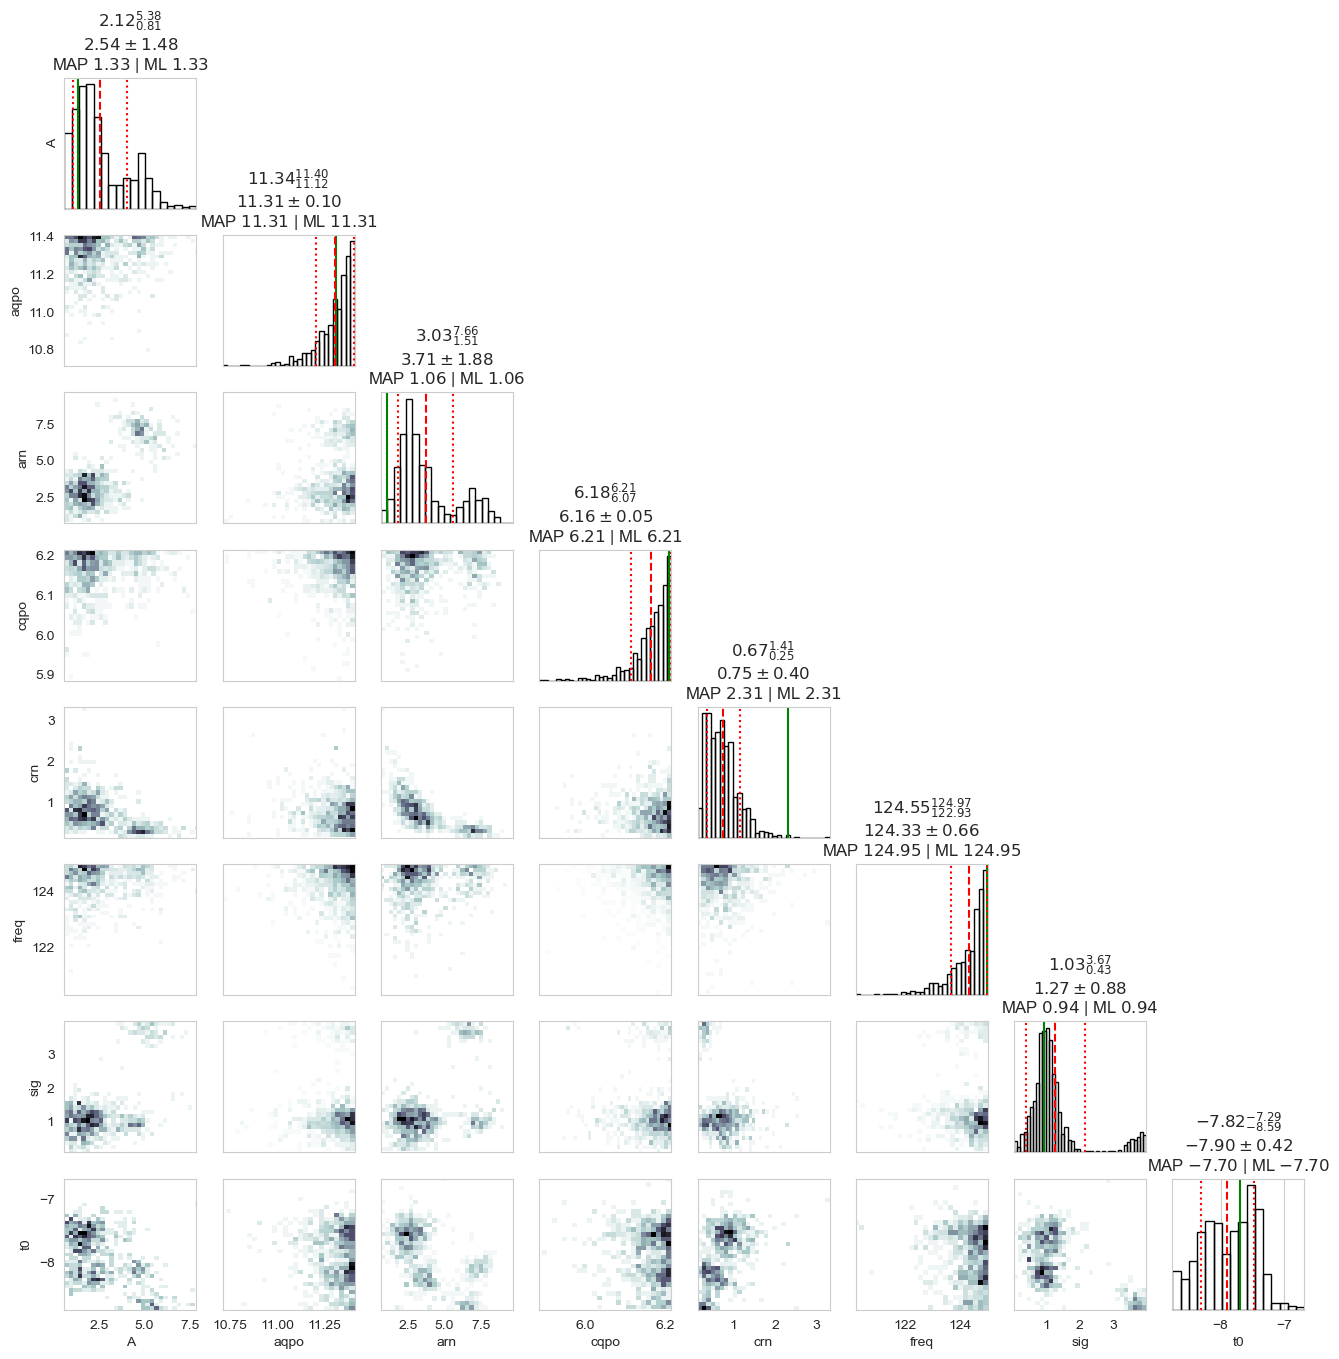

In [57]:
Exact_ns.plot_cornerplot(Results)

In [12]:
for i in range(1, len(times2)):
    print(times2[i]-times2[i-1])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
